# Figure6 Donors Overlap HeatMaps

** Plots **
* ** Overlap ** consistency heatmap
    * SPAN Tuned
    * SPAN Default
    * Golden (MACS2 + SICER) Default
* ** Jaccard ** consistency heatmap
    * SPAN Tuned
    * SPAN Default
    * Golden (MACS2 + SICER) Default

* Out of scope: SPAN No Input; SPAN Split

** Input** : 
* Peak Calling Summary - aging.tsv

# Overlap: Y20O20, SPAN

In [21]:
# Ensure project configured
! echo $WASHU_ROOT
! echo $PYTHONPATH

/mnt/stripe/washu
/mnt/stripe/washu:/mnt/stripe/washu:


In [22]:
from collections import OrderedDict, Counter
from itertools import repeat
import os

import pandas as pd
from pathlib import Path

from IPython.display import display

import downstream.bed_metrics as bm
import downstream.loci_of_interest as loi

import matplotlib
%matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina')
# %config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

N_THREADS = 8
CLEAR_CACHE = False

In [23]:
donors_df = pd.read_csv('/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/Y20O20_peaks_summary.tsv', sep='\t', comment='#')
donors_df.head()

,donor,modification,tool,peaks,length,frip,procedure,params,file,status
0,OD16,H3K27ac,macs_broad,26188,32950902,0.124598,tuned,broad0.1,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok
1,OD17,H3K27ac,macs_broad,26946,32248115,0.167880,tuned,broad0.01,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok
2,OD19,H3K27ac,macs_broad,23698,28051241,0.190469,tuned,broad1.0E-6,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok
3,YD2,H3K27ac,macs_broad,45139,44857667,0.089861,tuned,broad0.1,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok
4,OD4,H3K27ac,macs_broad,25625,32482411,0.439682,tuned,broad1.0E-8,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok


In [24]:
# File path example:
donors_df.loc[0, "file"]

'/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/macs_broad/OD_OD16_H3K27ac_broad0.1_peaks.broadPeak'

In [25]:
donors_df[(donors_df.modification == "H3K27ac") & (donors_df.donor == "YD6")]

,donor,modification,tool,peaks,length,frip,procedure,params,file,status
17,YD6,H3K27ac,macs_broad,12756,10502526,0.027218,tuned,broad0.1,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,failed
73,YD6,H3K27ac,macs_broad,12756,10502526,0.027218,default,broad0.1,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,failed
105,YD6,H3K27ac,span,17511,15847200,0.026452,tuned,200_1.0E-4_10,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,failed
155,YD6,H3K27ac,span,26,6600,0.000054,default,200_1.0E-6_5,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,failed


In [33]:
def color_annotator_hist(label):
    chunks = list(label.split("_"))
    hist, _donor, _tool = chunks
    color = {'H3K4me1':'lightblue', 'H3K4me3':'red', 'H3K27ac':'black',
             'H3K27me3':'green', 'H3K36me3':'lightgray'}[hist]

    return (("Histone", color),)

def build_donors_heatmap(donors_df, tools_config, title, metric_df_path, *, 
                         tuned = True, overlap_metric = True, hide_failed_tracks = False,
                         row_cluster=False, plot_path = None, threads = 4):
    procedure = "tuned" if tuned else "default"
    
    hists = tools_config.keys()
    
    # Collect data: -----------------------------------
    all_paths = []
    all_labels = []
    all_passed = []
    print("Input Data:".format(" only passed tracks" if hide_failed_tracks else ""))
    for h in hists:
        tool = tools_config[h]
        mask = (donors_df.modification == h) & (donors_df.tool == tool) & (donors_df.procedure == procedure)
        
        df_masked = donors_df[mask]
        idx2donor = list(zip(df_masked.index, df_masked.donor))
        idx2donor.sort(key=lambda v: (v[1][0:2], int(v[1][2:])))
        
        sorted_indexes = list(zip(*idx2donor))[0]
        df_masked = df_masked.loc[list(sorted_indexes),:]
        
        paths = [Path(p) for p in df_masked.file]
        labels = ["{}_{}_{}".format(h, d, tool) for d in df_masked.donor]
        
        passed = df_masked.status != "failed"
        print("  {}: {} {} [passed: {}, failed: {}]".format(h, procedure, tool, sum(passed), sum(~passed)))
        
        all_paths.extend(paths)
        all_labels.extend(labels)
        all_passed.extend(passed)
        
    # Metric: -----------------------------------
    print("\nMetrics table:")
    print(metric_df_path)
    if CLEAR_CACHE:
        if os.path.exists(metric_df_path):
            os.remove(metric_df_path)
            
    df = bm.load_or_build_metrics_table(all_paths, all_paths, Path(str(metric_df_path)),
                                        jaccard=not overlap_metric, threads=threads)
    assert df.index.tolist() == df.columns.tolist()
        
    # reorder lines to match all_paths in order to get correct labels and failed tracks order
    # important if CLEAR_CACHE is false
    all_paths_names = [p.name for p in all_paths]
    df = df.loc[all_paths_names, all_paths_names]
    # no order is same, so it is ok to update labels
    df.index = all_labels
    df.columns = all_labels

    if hide_failed_tracks:
        df = df.loc[all_passed, all_passed]

    # Plot: -----------------------------------
    metrics = "Jaccard" if not overlap_metric else "Overlap"
    annotator = color_annotator_hist
    
    g = bm.plot_metric_heatmap(metrics, #IM: {}".format(df_path.name), 
                               df,
                               save_to=plot_path,
                               row_cluster=row_cluster, 
                               col_cluster=False,
                               row_color_annotator=annotator,
                               col_color_annotator=annotator,
                               row_colors_ratio=0.025, col_colors_ratio=0.025,
                               # todo y/o
                               figsize=(10, 10), cbar=False,
                               show_or_save_plot=False)

    # replace donors names with hist modifications:
    filtered_labels = df.columns 
    hist_donors_cnt = Counter()
    for l in filtered_labels:
        hist = l.split("_")[0]
        hist_donors_cnt[hist] += 1
    
    hist_donors_counts = [hist_donors_cnt[h] for h in hists]
    
    ticks = [sum(hist_donors_counts[0:k]) + hist_donors_counts[k]/2 for k in range(len(hist_donors_counts))]
    g.ax_heatmap.set_xticks(ticks)
    g.ax_heatmap.set_xticklabels(hists, rotation="horizontal", horizontalalignment = 'center')
    g.ax_heatmap.set_yticks(ticks)
    g.ax_heatmap.set_yticklabels(hists, rotation="vertical", verticalalignment = 'center')

    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=90)
    
    # Turn off annotations
    g.ax_col_colors.set_yticks([])
    g.ax_row_colors.set_xticks([])

    g.ax_col_colors.set_title(title)
    
    # Turn off Y lables:
    if row_cluster == True:
        g.ax_heatmap.set_yticks([])
        
    bm.save_plot(plot_path)

# Overlap

## Tuned SPAN

Input Data:
  H3K4me1: tuned span [passed: 32, failed: 0]
  H3K4me3: tuned span [passed: 33, failed: 7]
  H3K27ac: tuned span [passed: 38, failed: 2]
  H3K27me3: tuned span [passed: 32, failed: 8]
  H3K36me3: tuned span [passed: 32, failed: 7]

Metrics table:
/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv
[Skipped]: Already exists /mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv


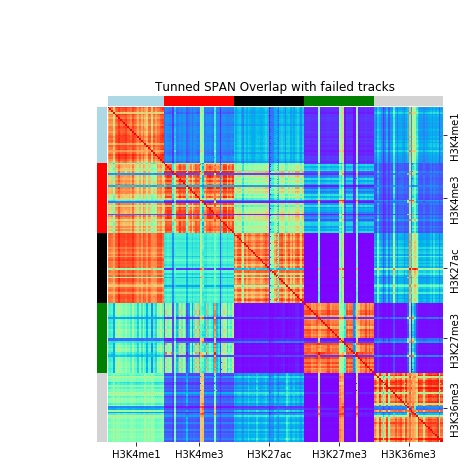

In [34]:
build_donors_heatmap(
    donors_df,
    OrderedDict(zip(['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K36me3'], repeat("span"))),
    "Tunned SPAN Overlap with failed tracks",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv",
    tuned = True, overlap_metric = True,
    threads=N_THREADS, hide_failed_tracks=False
)

Input Data:
  H3K4me1: tuned span [passed: 32, failed: 0]
  H3K4me3: tuned span [passed: 33, failed: 7]
  H3K27ac: tuned span [passed: 38, failed: 2]
  H3K27me3: tuned span [passed: 32, failed: 8]
  H3K36me3: tuned span [passed: 32, failed: 7]

Metrics table:
/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv
[Skipped]: Already exists /mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv


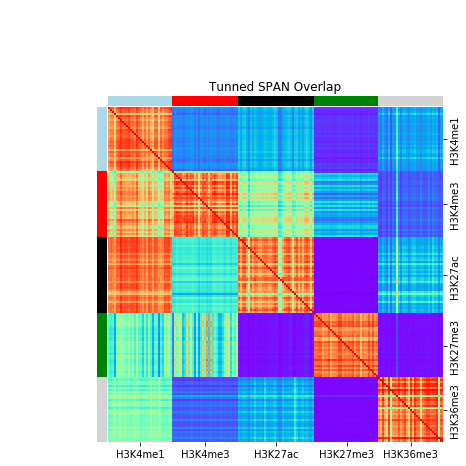

In [35]:
build_donors_heatmap(
    donors_df,
    OrderedDict(zip(['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K36me3'], repeat("span"))),
    "Tunned SPAN Overlap",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv",
    tuned = True, overlap_metric = True,
    threads=N_THREADS, hide_failed_tracks=True
)

Save to pdf file

In [37]:
build_donors_heatmap(
    donors_df,
    OrderedDict(zip(['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K36me3'], repeat("span"))),
    "Tunned SPAN Overlap",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv",
    plot_path="/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.pdf",
    tuned = True, overlap_metric = True, 
    threads=N_THREADS, hide_failed_tracks=True
)

Input Data:
  H3K4me1: tuned span [passed: 32, failed: 0]
  H3K4me3: tuned span [passed: 33, failed: 7]
  H3K27ac: tuned span [passed: 38, failed: 2]
  H3K27me3: tuned span [passed: 32, failed: 8]
  H3K36me3: tuned span [passed: 32, failed: 7]

Metrics table:
/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv
[Skipped]: Already exists /mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_tunned_span.csv


## Default SPAN

In [ ]:
build_donors_heatmap(
    donors_df,
    OrderedDict(zip(['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K36me3'], repeat("span"))),
    "Default SPAN Overlap",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_default_span.csv",
    tuned = False, overlap_metric = True,
    threads=N_THREADS, hide_failed_tracks=True
)

## Default GOLDEN

In [ ]:
build_donors_heatmap(
    donors_df,
    OrderedDict([
        *list(zip(['H3K4me1', 'H3K4me3', 'H3K27ac'], repeat("macs2"))),
        *list(zip(['H3K27me3', 'H3K36me3'], repeat("sicer")))
    ]),
    "Default MACS2 & SICER Overlap",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_overlap_default_golden.csv",
    tuned = False, overlap_metric = True,
    threads=N_THREADS, hide_failed_tracks=True
)

# Jaccard

## Tuned SPAN

In [ ]:
build_donors_heatmap(
    donors_df,
    OrderedDict(zip(['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K36me3'], repeat("span"))),
    "Tuned SPAN Jaccard",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_jaccard_tuned_span.csv",
    tuned = True, overlap_metric = False,
    threads=N_THREADS, hide_failed_tracks=True
)

## Default SPAN

In [ ]:
build_donors_heatmap(
    donors_df,
    OrderedDict(zip(['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K36me3'], repeat("span"))),
    "Default SPAN Jaccard",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_jaccard_default_span.csv",
    tuned = False, overlap_metric = False,
    threads=N_THREADS, hide_failed_tracks=True
)

## Default GOLDEN

In [ ]:
build_donors_heatmap(
    donors_df,
    OrderedDict([
        *list(zip(['H3K4me1', 'H3K4me3', 'H3K27ac'], repeat("macs2"))),
        *list(zip(['H3K27me3', 'H3K36me3'], repeat("sicer")))
    ]),
    "Default MACS2 & SICER Jaccard",
    "/mnt/stripe/bio/experiments/configs/Y20O20/reports/heatmap_jaccard_default_golden.csv",
    tuned = False, overlap_metric = False,
    threads=N_THREADS, hide_failed_tracks=True
)